<a href="https://colab.research.google.com/github/Harish-lvrk/PyTorch/blob/main/ann_fashion_mnist_pytorch_gpu_optimized_optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ANN on Fashion MNIST with PyTorch, GPU, and Optuna Hyperparameter Tuning

In [ ]:
!pip install optuna mlflow optuna-integration[mlflow] --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 2.8 MB/s eta 0:00:00


## 1. Setup and Imports

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import optuna
import mlflow

## 2. Device Configuration

In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)

# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## 3. Load and Visualize Data

In [ ]:
# Note: Make sure 'fmnist_small.csv' is uploaded to your Colab environment
df = pd.read_csv('/content/fmnist_small.csv')
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (6000, 785)


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,9,0,0,0,0,0,0,0,0,0,...,0,7,0,50,205,196,213,165,0,0
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,142,142,142,21,0,3,0,0,0,0
3,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8,0,0,0,0,0,0,0,0,0,...,213,203,174,151,188,10,0,0,0,0


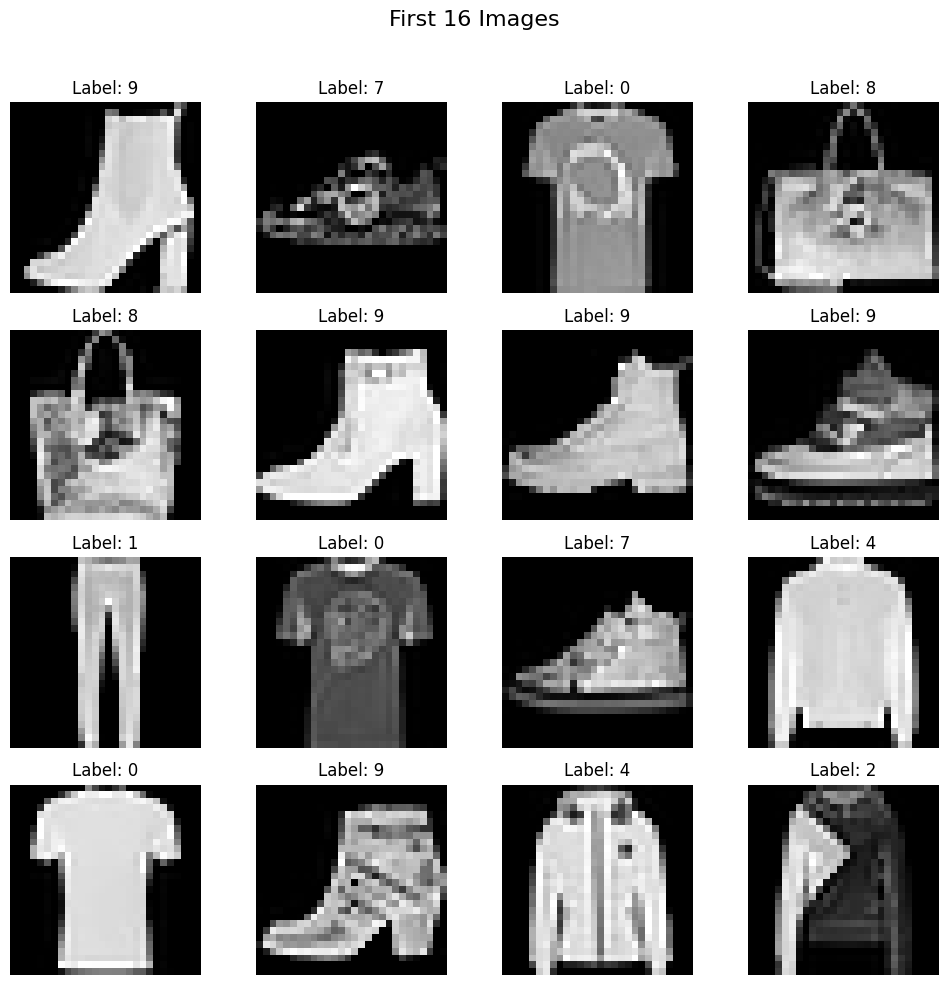

In [ ]:
# Create a 4x4 grid of images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
fig.suptitle("First 16 Images", fontsize=16)

# Plot the first 16 images from the dataset
for i, ax in enumerate(axes.flat):
    img = df.iloc[i, 1:].values.reshape(28, 28)  # Reshape to 28x28
    ax.imshow(img, cmap='gray')  # Display in grayscale
    ax.axis('off')  # Remove axis for a cleaner look
    ax.set_title(f"Label: {df.iloc[i, 0]}")  # Show the label

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()

## 4. Preprocessing and Dataset Creation

In [ ]:
# Separate features (X) and labels (y)
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize pixel values to be between 0 and 1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        # Convert to PyTorch tensors
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

train_dataset = CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

## 5. Neural Network Model Definition

In [ ]:
class MyNN(nn.Module):
    def __init__(self, input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate):
        super().__init__()

        layers = []

        # Dynamically build the hidden layers
        for i in range(num_hidden_layers):
            layers.append(nn.Linear(input_dim, neurons_per_layer))
            layers.append(nn.BatchNorm1d(neurons_per_layer))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = neurons_per_layer # The input for the next layer is the output of this one

        # Add the final output layer
        layers.append(nn.Linear(neurons_per_layer, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

## 6. Optuna Objective Function

In [ ]:
def objective(trial):
    # Hyperparameter search space
    num_hidden_layers = trial.suggest_int("num_hidden_layers", 1, 5)
    neurons_per_layer = trial.suggest_int("neurons_per_layer", 16, 128, step=16)
    epochs = trial.suggest_int("epochs", 10, 50, step=10)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-1, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    optimizer_name = trial.suggest_categorical("optimizer", ['Adam', 'SGD', 'RMSprop'])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    # Model initialization
    input_dim = 784
    output_dim = 10
    model = MyNN(input_dim, output_dim, num_hidden_layers, neurons_per_layer, dropout_rate)
    model.to(device)

    # Loss function and Optimizer Selection (CORRECTED LOGIC)
    criterion = nn.CrossEntropyLoss()
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else: # RMSprop
        optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training Loop
    model.train()
    for epoch in range(epochs):
        for batch_features, batch_labels in train_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluation Loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_features, batch_labels in test_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            _, predicted = torch.max(outputs, 1)
            total += batch_labels.shape[0]
            correct += (predicted == batch_labels).sum().item()

    accuracy = correct / total
    return accuracy

## 7. Run Hyperparameter Optimization with MLflow Logging

In [ ]:
study = optuna.create_study(direction='maximize')

# Setup MLflow callback
mlflow_callback = optuna.integration.MLflowCallback(
    tracking_uri=mlflow.get_tracking_uri(),
    metric_name='accuracy',
)

# Start the optimization (CORRECTED SYNTAX)
# You can change n_trials to a larger number for a more thorough search.
study.optimize(objective, n_trials=50, callbacks=[mlflow_callback])

[I 2025-09-19 12:06:43,301] A new study created in memory with name: no-name-5dcd74aa-1f2e-452c-a7db-d241c18805e4
/tmp/ipython-input-2080727612.py:4: ExperimentalWarning: MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.
  mlflow_callback = optuna.integration.MLflowCallback(
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
[I 2025-09-19 12:07:02,280] Trial 0 finished with value: 0.7933333333333333 and parameters: {'num_hidden_layers': 3, 'neurons_per_layer': 64, 'epochs': 40, 'learning_rate': 0.04132097571189788, 'dropout_rate': 0.30000000000000004, 'batch_size': 128, 'optimizer': 'RMSprop', 'weight_decay': 1.2946225684279446e-05}. Best is trial 0 with value: 0.7933333333333333.
2025/09/19 12:07:02 INFO mlflow.tracking.fluent: Experiment with name 'no-name-5dcd74aa-1f2e-

## 8. Display Best Results

In [ ]:
print("Best trial found:")
print(f"  Value (Accuracy): {study.best_value:.4f}")
print("  Params: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")

Best trial found:
  Value (Accuracy): 0.8458
  Params: 
    num_hidden_layers: 3
    neurons_per_layer: 128
    epochs: 50
    learning_rate: 0.0010660366117430083
    dropout_rate: 0.5
    batch_size: 64
    optimizer: Adam
    weight_decay: 0.0001050699184793429


## 9. Visualize Results with MLflow UI

Now we will launch the MLflow UI and expose it with `ngrok` so you can access it from your browser.

In [ ]:
# Install ngrok
!pip install pyngrok

In [ ]:
# Run the MLflow UI server in the background on port 5000
get_ipython().system_raw('mlflow ui --port 5000 &')

In [ ]:
from pyngrok import ngrok
from google.colab import userdata

# Terminate any existing tunnels to avoid errors
ngrok.kill()

# Get the authtoken from Colab secrets
NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')

# Authenticate ngrok
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open a tunnel to the MLflow server
mlflow_url = ngrok.connect(5000)
print(f"MLflow Tracking UI: {mlflow_url}")
# auth token 32v2pEDNUcOsPdX31vaAYrJMdqU_4NtzfQ31sTGZzc87uogkk

MLflow Tracking UI: NgrokTunnel: "https://6237e2ae0cac.ngrok-free.app" -> "http://localhost:5000"


**➡️ Click the URL above to open the MLflow dashboard and explore your experiment runs!**